# Linear Regression Applied: Insurance Cost Prediction

Here we'll be working through [Assignment 2](https://jovian.ai/aakashns/02-insurance-linear-regression) of the [Pytorch Zero-to-GANS course](https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans), and demonstrating how to use personal data to predict annual medical costs.

In [1]:
project_name = 'pytorch-first-model'
assignment_name = 'zerotogans-a2'

First let's import the necessary tools.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

## Step 1: Download and Explore Dataset

The dataset is public domain and available on [Kaggle](https://www.kaggle.com/mirichoi0218/insurance?select=insurance.csv), but Jovian have made it more accessibly downloadable, so we'll get it from there.

In [3]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '../data')

0it [00:00, ?it/s]

 59%|█████▉    | 32768/55628 [00:00<00:00, 218347.69it/s]

In [4]:
df_raw = pd.read_csv(f'./data/{DATA_FILENAME}')
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


The assignment wants us to personalize the data by taking a randomized sample of the data using our name as a source of random numbers.

In [5]:
def personalize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [6]:
my_name = 'Peter'
df = personalize_dataset(df_raw, my_name)
df.head()

,age,sex,bmi,children,smoker,charges
240,23,female,37.0367,2,yes,44673.488828
651,53,female,39.9960,1,no,12272.464760
761,23,male,35.5520,1,no,2803.667800
836,36,male,31.8150,0,no,5106.590280
1147,20,female,32.2392,0,no,2623.419808


Now let's do some very basic initial exploration of the data.

In [7]:
num_rows, num_cols = df.shape
print(f'The dataframe has {num_rows} rows and {num_cols} columns')

The dataframe has 1271 rows and 6 columns


In [8]:
col_titles = df.columns
input_cols = col_titles.values
print(f'The dataframe column headings are {list(col_titles)}')

The dataframe column headings are ['age', 'sex', 'bmi', 'children', 'smoker', 'charges']


57344it [00:19, 218347.69it/s]                           

In [9]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
charges     float64
dtype: object

In [10]:
categorical_cols = ['sex', 'smoker']

Looking at the types of the variables, we can see that `sex` is a binary categorical variable...

In [11]:
df.sex.unique()

array(['female', 'male'], dtype=object)

...and so is `smoker`.

In [12]:
df.smoker.unique()

array(['yes', 'no'], dtype=object)

The target variable that we are interested in is `charges`. We can easily find its statistics, and plot its histogram.

In [13]:
output_cols = ['charges']
df.charges.describe()

count     1271.000000
mean     15513.173557
std      14125.570520
min       1301.373724
25%       5536.462094
50%      10958.810406
75%      19472.175274
max      73973.696492
Name: charges, dtype: float64

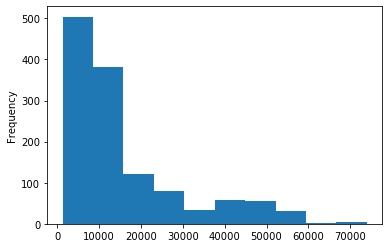

In [14]:
df.charges.plot.hist()

## Step 2: Prepare Dataset for Training

We're using PyTorch, so we need to convert our Pandas dataframe into a PyTorch tensor.

[Aakash suggests](https://jovian.ai/aakashns/02-insurance-linear-regression/v/5#C29) that we first turn it into a NumPy array, using his function.

In [15]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [16]:
inputs_array, targets_array = dataframe_to_arrays(df)
inputs_array, targets_array

(array([[2.30000000e+01, 0.00000000e+00, 3.70367000e+01, 2.00000000e+00,
         1.00000000e+00, 4.46734888e+04],
        [5.30000000e+01, 0.00000000e+00, 3.99960000e+01, 1.00000000e+00,
         0.00000000e+00, 1.22724648e+04],
        [2.30000000e+01, 1.00000000e+00, 3.55520000e+01, 1.00000000e+00,
         0.00000000e+00, 2.80366780e+03],
        ...,
        [5.90000000e+01, 0.00000000e+00, 3.71326500e+01, 1.00000000e+00,
         1.00000000e+00, 5.55602780e+04],
        [5.30000000e+01, 0.00000000e+00, 3.35825000e+01, 0.00000000e+00,
         0.00000000e+00, 1.22552660e+04],
        [4.80000000e+01, 0.00000000e+00, 3.36633000e+01, 0.00000000e+00,
         0.00000000e+00, 9.60906961e+03]]),
 array([[44673.488828],
        [12272.46476 ],
        [ 2803.6678  ],
        ...,
        [55560.277966],
        [12255.26602 ],
        [ 9609.069612]]))

Now we instantiate PyTorch tensors from those NumPy arrays.

In [17]:
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

print(f'Inputs tensor instantiated with dtype {inputs.dtype}')
print(f'Targets tensor instantiated with dtype {targets.dtype}')

Inputs tensor instantiated with dtype torch.float32
Targets tensor instantiated with dtype torch.float32


Next, we need to create PyTorch datasets and data loaders for training and validation. We start by creating a `TensorDataset`.

In [18]:
dataset = TensorDataset(inputs, targets)

In [19]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

# Use the random_split function to split dataset into 2 parts of the desired length
train_ds, val_ds = random_split(dataset, [train_size, val_size])

Now we can create data loaders for training and validation.

In [20]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working so far:

In [26]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)

inputs: tensor([[4.2000e+01, 1.0000e+00, 2.8593e+01, 3.0000e+00, 1.0000e+00, 3.8033e+04],
        [3.8000e+01, 0.0000e+00, 2.7538e+01, 1.0000e+00, 0.0000e+00, 7.6039e+03],
        [6.2000e+01, 1.0000e+00, 3.2335e+01, 0.0000e+00, 1.0000e+00, 5.3024e+04],
        [3.0000e+01, 0.0000e+00, 2.3892e+01, 3.0000e+00, 1.0000e+00, 2.1768e+04],
        [3.8000e+01, 1.0000e+00, 1.6983e+01, 2.0000e+00, 0.0000e+00, 7.7030e+03],
        [5.0000e+01, 0.0000e+00, 2.8108e+01, 3.0000e+00, 0.0000e+00, 2.2909e+04],
        [2.2000e+01, 1.0000e+00, 3.1663e+01, 1.0000e+00, 0.0000e+00, 3.0662e+03],
        [2.1000e+01, 1.0000e+00, 3.5885e+01, 0.0000e+00, 0.0000e+00, 1.7777e+03],
        [6.1000e+01, 1.0000e+00, 4.3834e+01, 0.0000e+00, 0.0000e+00, 1.4586e+04],
        [2.3000e+01, 1.0000e+00, 3.3027e+01, 3.0000e+00, 0.0000e+00, 4.1661e+03],
        [6.1000e+01, 1.0000e+00, 3.6219e+01, 0.0000e+00, 1.0000e+00, 5.4055e+04],
        [4.6000e+01, 1.0000e+00, 2.2523e+01, 0.0000e+00, 0.0000e+00, 8.2906e+03],
        

## Step 3: Create a Linear Regression Model

The model is a straightforward linear regression. I've decided to use `mse_loss`  as my [loss function](https://pytorch.org/docs/stable/nn.functional.html#loss-functions).

In [27]:
input_size = len(input_cols)
output_size = len(output_cols)

In [28]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,output_size)                 
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)        
        # Calcuate loss
        loss = nn.functional.mse_loss(out,targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = nn.functional.mse_loss(out,targets)
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Having defined the `InsuranceModel` class we can now use it.

In [29]:
model = InsuranceModel()

We can see the weights and biases of the model by listing the `model.parameters`.

In [32]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0368,  0.2072, -0.3085,  0.1933, -0.0152, -0.0075]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.2817], requires_grad=True)]

## Step 4: Train the Model to Fit the Data

To train the model, we define a generic training loop that can be easily used for any problem.

In [33]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [34]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 457238144.0}


## Step 5: Make Predictions Using the Trained Model

## Step 6: Commit to Jovian

In [ ]:
# import jovian
# jovian.commit(project=project_name, environment=None)
# jovian.submit(assignment=assignment_name)